In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

from sklearn.preprocessing import StandardScaler

from pylab import rcParams
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
rcParams['figure.figsize'] = (20,10)
rcParams['figure.dpi'] = (100)

In [ ]:
confirmed = pd.read_csv('/content/drive/MyDrive/time_series_covid19_confirmed_US.csv')
confirmed.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4268,4305,4336,4546,4645,4705,4770,4847,4879,4902,4970,4998,5075,5103,5154,5184,5198,5227,5257,5270,5327,5358,5376,5407,5440,5499,5554,5596,5596,5669,5683,5723,5753,5811,5824,5856,5869,5881,5910,5930
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13955,14064,14187,14440,14656,14845,15052,15202,15327,15417,15572,15701,15841,16002,16176,16251,16346,16513,16653,16798,16981,17128,17256,17333,17496,17629,17779,17922,17922,18126,18211,18344,18418,18494,18568,18668,18723,18763,18824,18888
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1528,1530,1533,1575,1597,1614,1634,1648,1658,1663,1679,1685,1696,1712,1723,1729,1730,1738,1760,1778,1793,1805,1827,1834,1882,1898,1920,1931,1931,1951,1956,1966,1981,1989,1994,2002,2008,2008,2019,2024
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1863,1882,1885,1923,1944,1981,2015,2038,2051,2060,2090,2109,2113,2130,2144,2151,2162,2170,2188,2198,2212,2223,2223,2229,2247,2261,2271,2284,2284,2307,2309,2319,2321,2327,2331,2334,2339,2346,2362,2368
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4729,4746,4771,4849,4898,4957,5018,5047,5066,5080,5134,5170,5219,5264,5292,5304,5308,5320,5376,5411,5439,5462,5473,5485,5517,5568,5612,5655,5655,5713,5720,5745,5768,5842,5871,5908,5915,5920,5929,5937


In [ ]:
confirmed.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key'], axis=1, inplace=True)
confirmed.reset_index(drop=True)
confirmed.head()

,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21
0,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4268,4305,4336,4546,4645,4705,4770,4847,4879,4902,4970,4998,5075,5103,5154,5184,5198,5227,5257,5270,5327,5358,5376,5407,5440,5499,5554,5596,5596,5669,5683,5723,5753,5811,5824,5856,5869,5881,5910,5930
1,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13955,14064,14187,14440,14656,14845,15052,15202,15327,15417,15572,15701,15841,16002,16176,16251,16346,16513,16653,16798,16981,17128,17256,17333,17496,17629,17779,17922,17922,18126,18211,18344,18418,18494,18568,18668,18723,18763,18824,18888
2,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1528,1530,1533,1575,1597,1614,1634,1648,1658,1663,1679,1685,1696,1712,1723,1729,1730,1738,1760,1778,1793,1805,1827,1834,1882,1898,1920,1931,1931,1951,1956,1966,1981,1989,1994,2002,2008,2008,2019,2024
3,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1863,1882,1885,1923,1944,1981,2015,2038,2051,2060,2090,2109,2113,2130,2144,2151,2162,2170,2188,2198,2212,2223,2223,2229,2247,2261,2271,2284,2284,2307,2309,2319,2321,2327,2331,2334,2339,2346,2362,2368
4,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4729,4746,4771,4849,4898,4957,5018,5047,5066,5080,5134,5170,5219,5264,5292,5304,5308,5320,5376,5411,5439,5462,5473,5485,5517,5568,5612,5655,5655,5713,5720,5745,5768,5842,5871,5908,5915,5920,5929,5937


In [ ]:
confirmed_NJ = confirmed[confirmed['Province_State']=='New Jersey']
confirmed_NJ.drop(['Province_State'], axis=1, inplace=True)
confirmed_NJ = confirmed_NJ.sum(axis=0)
confirmed_NJ.tail()

2/6/21     717835
2/7/21     722167
2/8/21     724728
2/9/21     728304
2/10/21    732674
dtype: int64

In [ ]:
def reverse_cumsum(array):
  l = []
  l.append(array[0])
  for i in range(len(array)-1):
    l.append(array[i+1] - array[i])
  return np.array(l)

In [ ]:
confirmed_NJ = confirmed_NJ.to_numpy()
NJ_data = reverse_cumsum(confirmed_NJ)
NJ_data[-10:]

array([3517, 3150, 2311, 3289, 4228, 4511, 4332, 2561, 3576, 4370])

In [ ]:
'''neg = [i for i in range(len(NJ_data)) if NJ_data[i]<0]
for i in neg:
  NJ_data[i] = (NJ_data[i-3]+NJ_data[i-2]+NJ_data[i-1])/3

NJ_data'''

'neg = [i for i in range(len(NJ_data)) if NJ_data[i]<0]\nfor i in neg:\n  NJ_data[i] = (NJ_data[i-3]+NJ_data[i-2]+NJ_data[i-1])/3\n\nNJ_data'

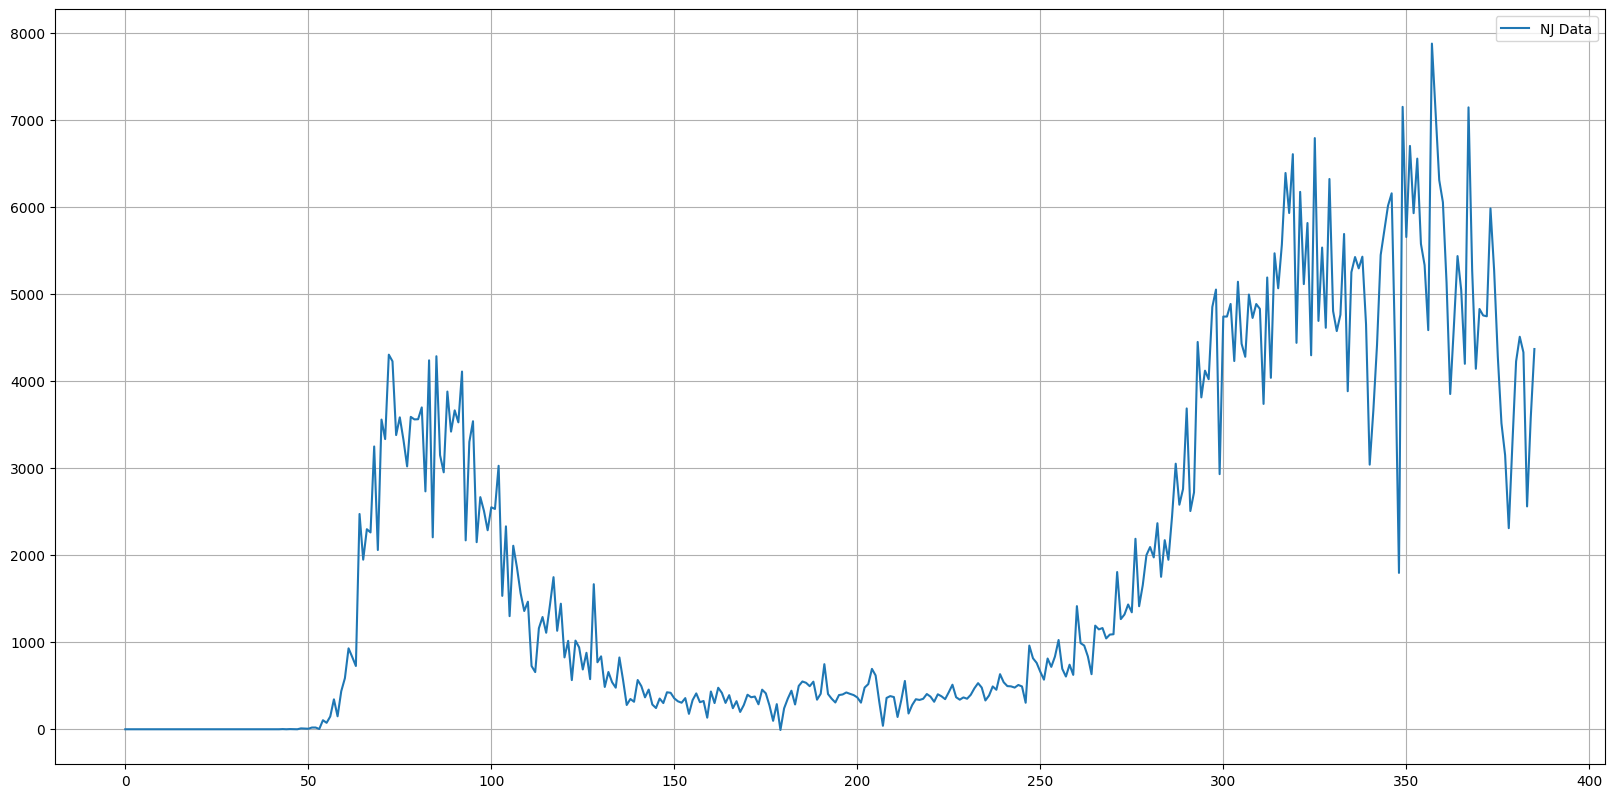

In [ ]:
plt.plot(NJ_data, label='NJ Data')
plt.legend()
plt.grid()
plt.show()

# Log Transformation

In [ ]:
NJ_log = Log(NJ_data)
NJ_log[-10:]

array([2.08368254, 1.98787435, 1.72668747, 2.02524931, 2.24664946,
       2.30478268, 2.26840764, 1.81188884, 2.0982633 , 2.27624112])

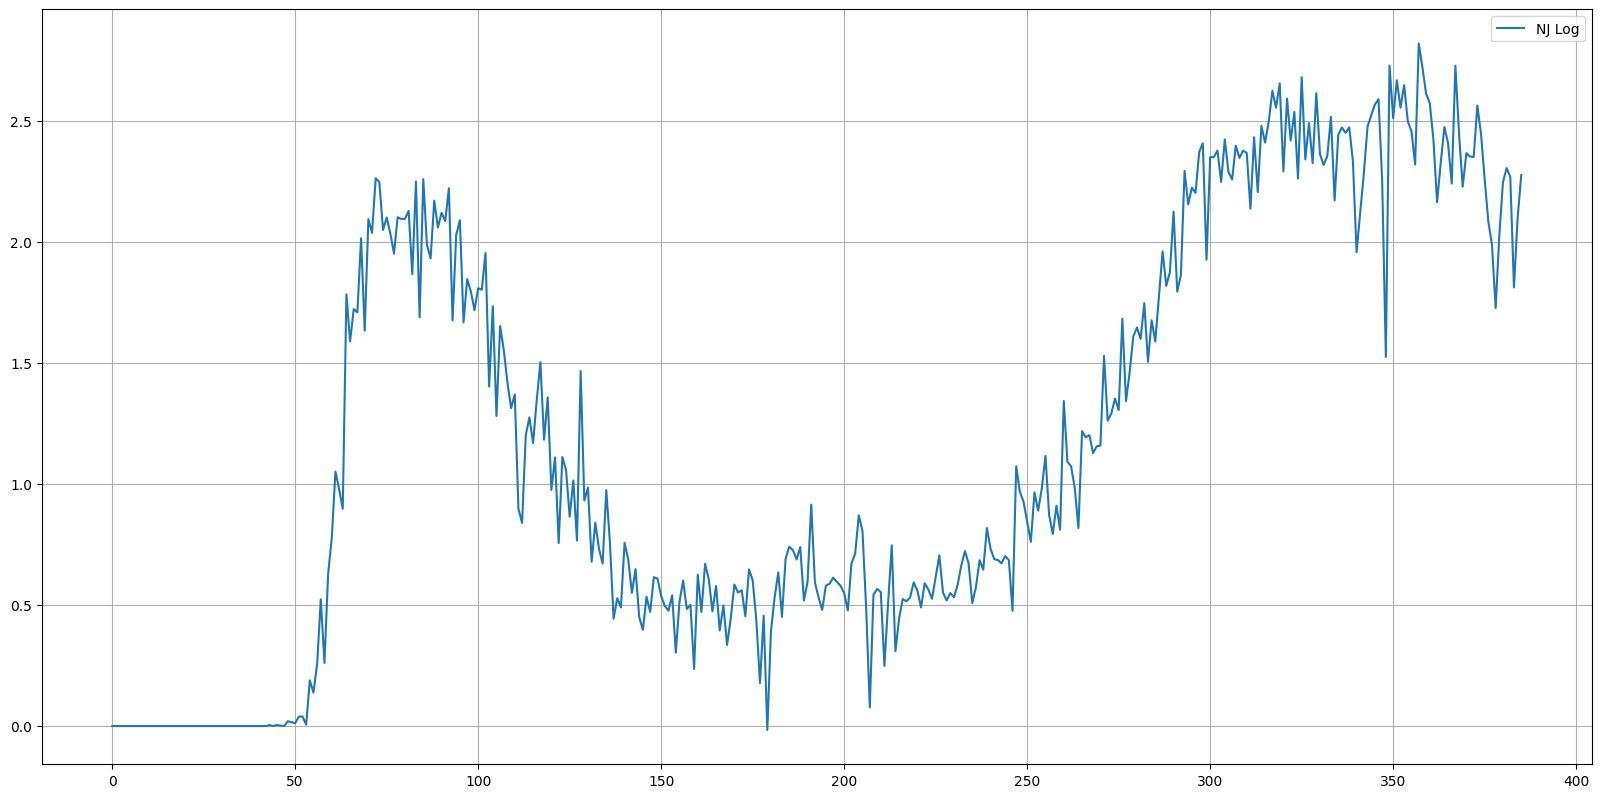

In [ ]:
plt.plot(NJ_log, label='NJ Log')
plt.legend()
plt.grid()
plt.show()

# Smooth Data

In [ ]:
out[1][0:45] = 0
NJ = out[1].copy()

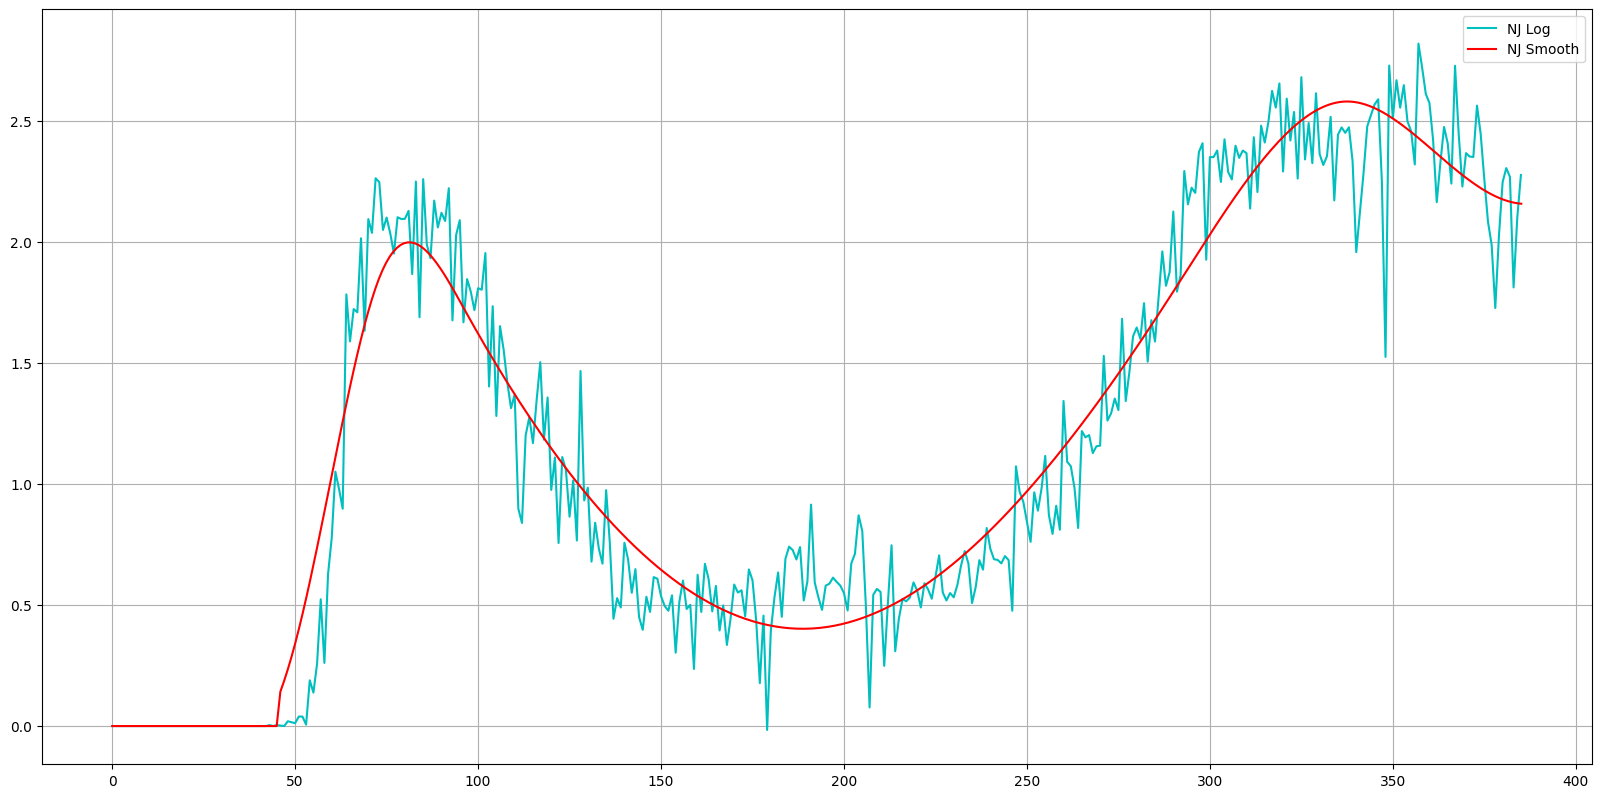

In [ ]:
plt.plot(data[0], data[1], 'c-', label='NJ Log')
plt.plot(out[0], NJ, 'r', label='NJ Smooth')

plt.grid()
plt.legend()
plt.show()

# Data Distribution

In [ ]:
train_size = int(len(NJ)*0.70)
val_size = int(len(NJ)*0.85)

train = NJ[:train_size]
val = NJ[train_size:val_size]
test = NJ[val_size:]


train_NJ = NJ_log[:train_size]
val_NJ = NJ_log[train_size:val_size]
test_NJ = NJ_log[val_size:]

In [ ]:
print(train.shape)
print(val.shape)
print(test.shape)

(270,)
(58,)
(58,)


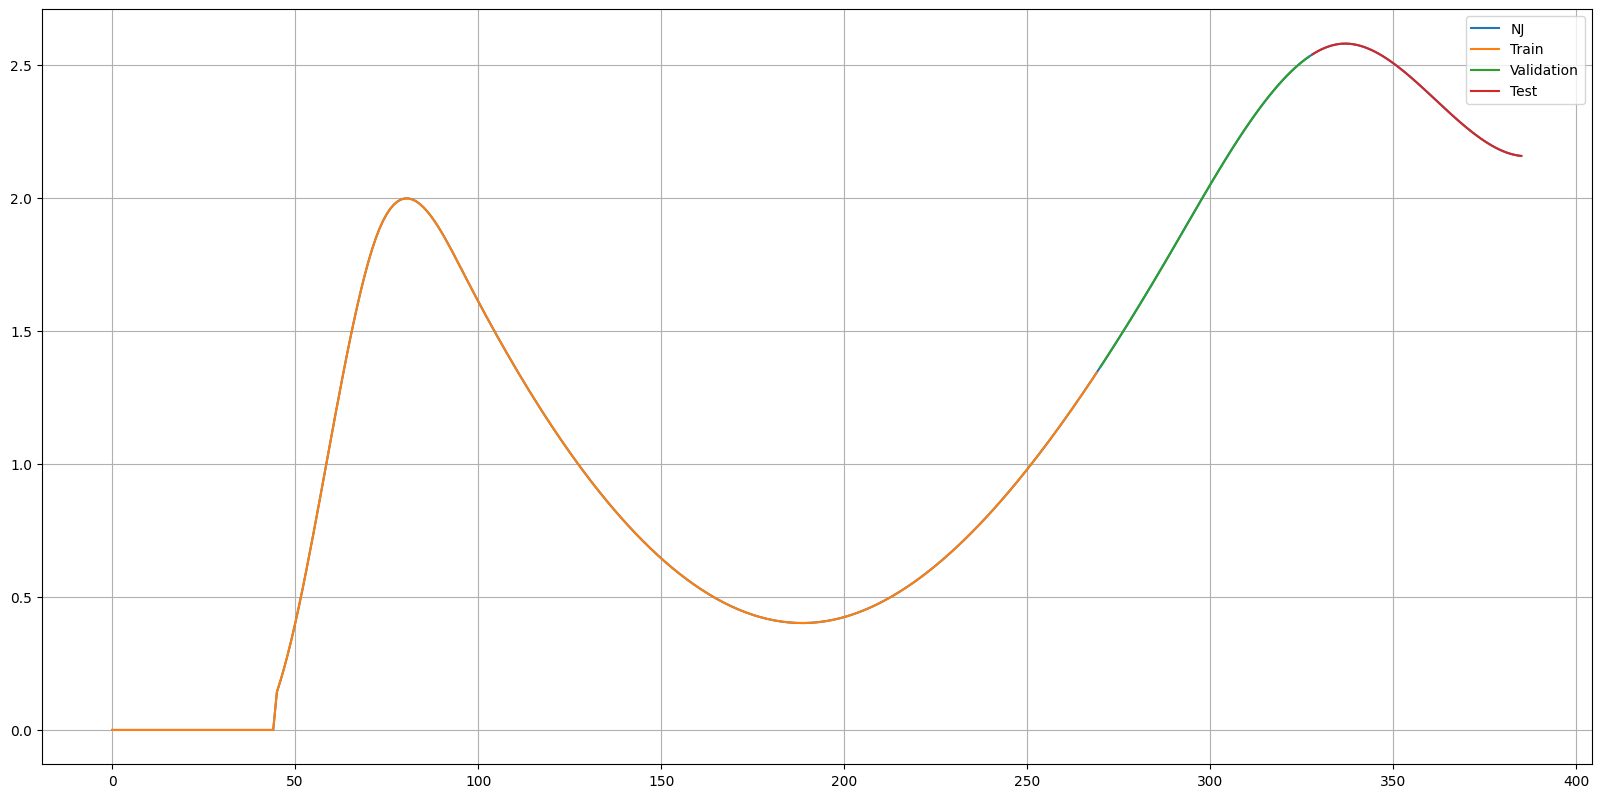

In [ ]:
plt.plot(NJ, label='NJ')
plt.plot(train, label='Train')
plt.plot(np.arange(train_size, val_size), val, label='Validation')
plt.plot(np.arange(val_size, len(NJ)), test, label='Test')

plt.grid()
plt.legend(loc='best')
plt.show()

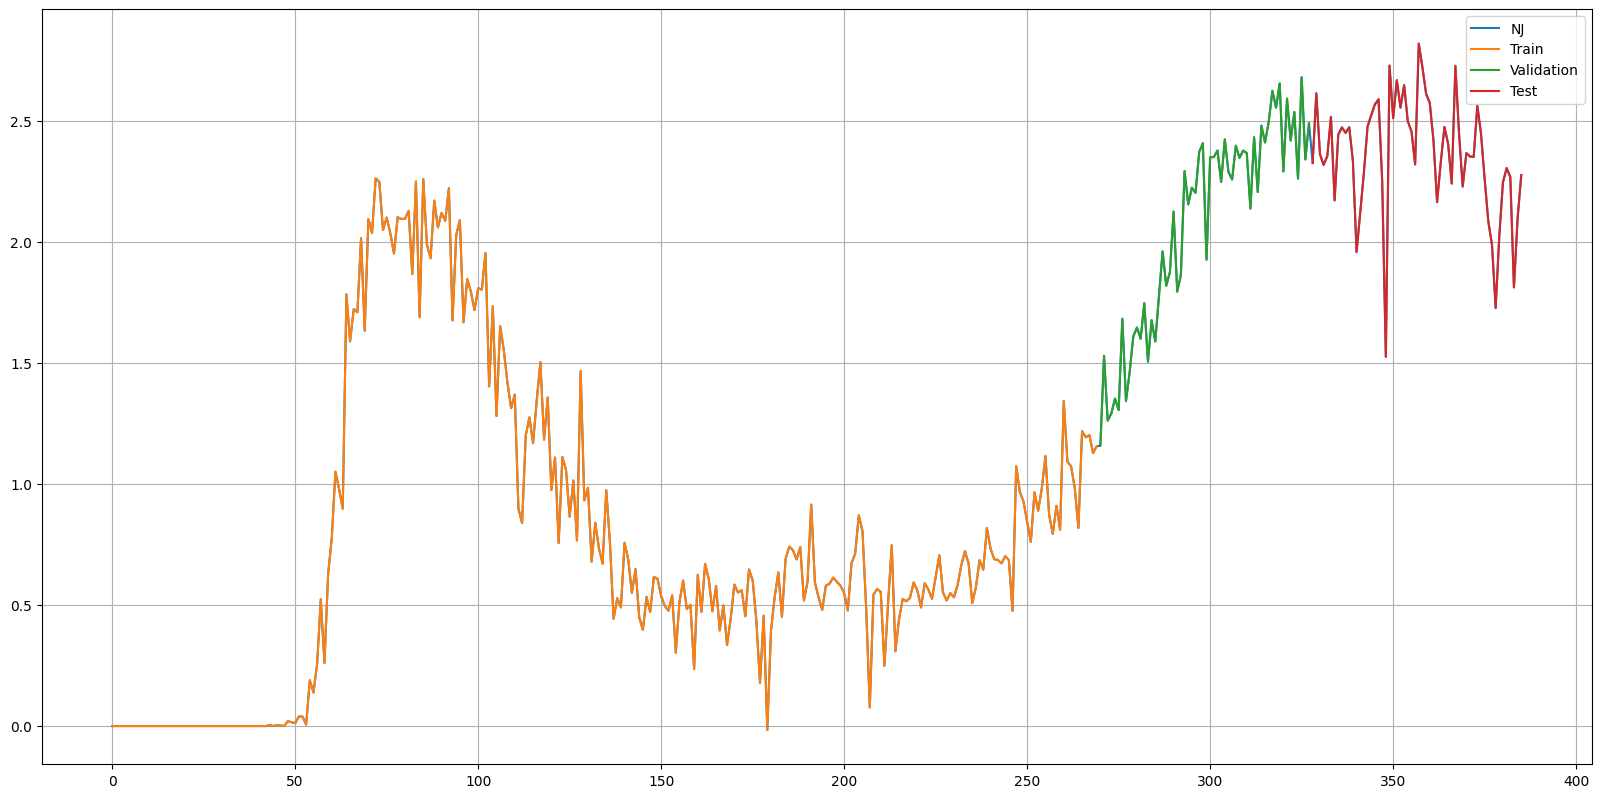

In [ ]:
plt.plot(NJ_log, label='NJ')
plt.plot(train_NJ, label='Train')
plt.plot(np.arange(train_size, val_size), val_NJ, label='Validation')
plt.plot(np.arange(val_size, len(NJ)), test_NJ, label='Test')

plt.grid()
plt.legend(loc='best')
plt.show()

# Data Standardization (Normalization)

In [ ]:
scaler = StandardScaler()

train_scl = scaler.fit_transform(train.reshape(-1,1))
val_scl = scaler.transform(val.reshape(-1,1))
test_scl = scaler.transform(test.reshape(-1,1))

print(len(train_scl), len(val_scl), len(test_scl))

270 58 58


In [ ]:
scaler_NJ = StandardScaler()

train_scl_NJ = scaler_NJ.fit_transform(train_NJ.reshape(-1,1))
val_scl_NJ = scaler_NJ.transform(val_NJ.reshape(-1,1))
test_scl_NJ = scaler_NJ.transform(test_NJ.reshape(-1,1))

# Dataset Creation

In [ ]:
def create_dataset(array, timesteps=1):
  X, y = [], []
  for i in range(len(array) - timesteps):
    X.append(array[i:(i + timesteps)])
    y.append(array[i + timesteps])
  return np.array(X), np.array(y)

In [ ]:
TIME_STEPS = 5
n_features = 1
BATCH_SIZE = 1
n_epochs = 200

In [ ]:
X_train, y_train = create_dataset(array=train_scl, timesteps=TIME_STEPS)

X_val, y_val = create_dataset(array=val_scl, timesteps=TIME_STEPS)

X_test, y_test = create_dataset(array=test_scl, timesteps=TIME_STEPS)


print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(265, 5, 1) (53, 5, 1) (53, 5, 1)
(265, 1) (53, 1) (53, 1)


In [ ]:
X_train_NJ, y_train_NJ = create_dataset(array=train_scl_NJ, timesteps=TIME_STEPS)

X_val_NJ, y_val_NJ = create_dataset(array=val_scl_NJ, timesteps=TIME_STEPS)

X_test_NJ, y_test_NJ = create_dataset(array=test_scl_NJ, timesteps=TIME_STEPS)

# Sequential Model

In [ ]:
import tensorflow as tf
import tensorboard
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=n_epochs, shuffle=False, 
                    verbose=1, batch_size=BATCH_SIZE, 
                    validation_data=(X_val, y_val),
                    callbacks=[rLRp, tb])

Epoch 1/150
265/265 [==============================] - 5s 10ms/step - loss: 0.3668 - val_loss: 0.9679
Epoch 2/150
265/265 [==============================] - 2s 6ms/step - loss: 0.0966 - val_loss: 1.6006
Epoch 3/150
265/265 [==============================] - 2s 6ms/step - loss: 0.1159 - val_loss: 1.8900
Epoch 4/150
265/265 [==============================] - 1s 6ms/step - loss: 0.1359 - val_loss: 2.1256
Epoch 5/150
265/265 [==============================] - 2s 7ms/step - loss: 0.1164 - val_loss: 2.1308
Epoch 6/150
265/265 [==============================] - 1s 5ms/step - loss: 0.1053 - val_loss: 2.4701

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/150
265/265 [==============================] - 2s 6ms/step - loss: 0.3081 - val_loss: 1.6412
Epoch 8/150
265/265 [==============================] - 1s 6ms/step - loss: 0.1787 - val_loss: 1.2406
Epoch 9/150
265/265 [==============================] - 2s 6ms/step - loss: 0.1197 - val_loss: 0.9119
Epoch 10

> ## Loss vs Validation Loss 

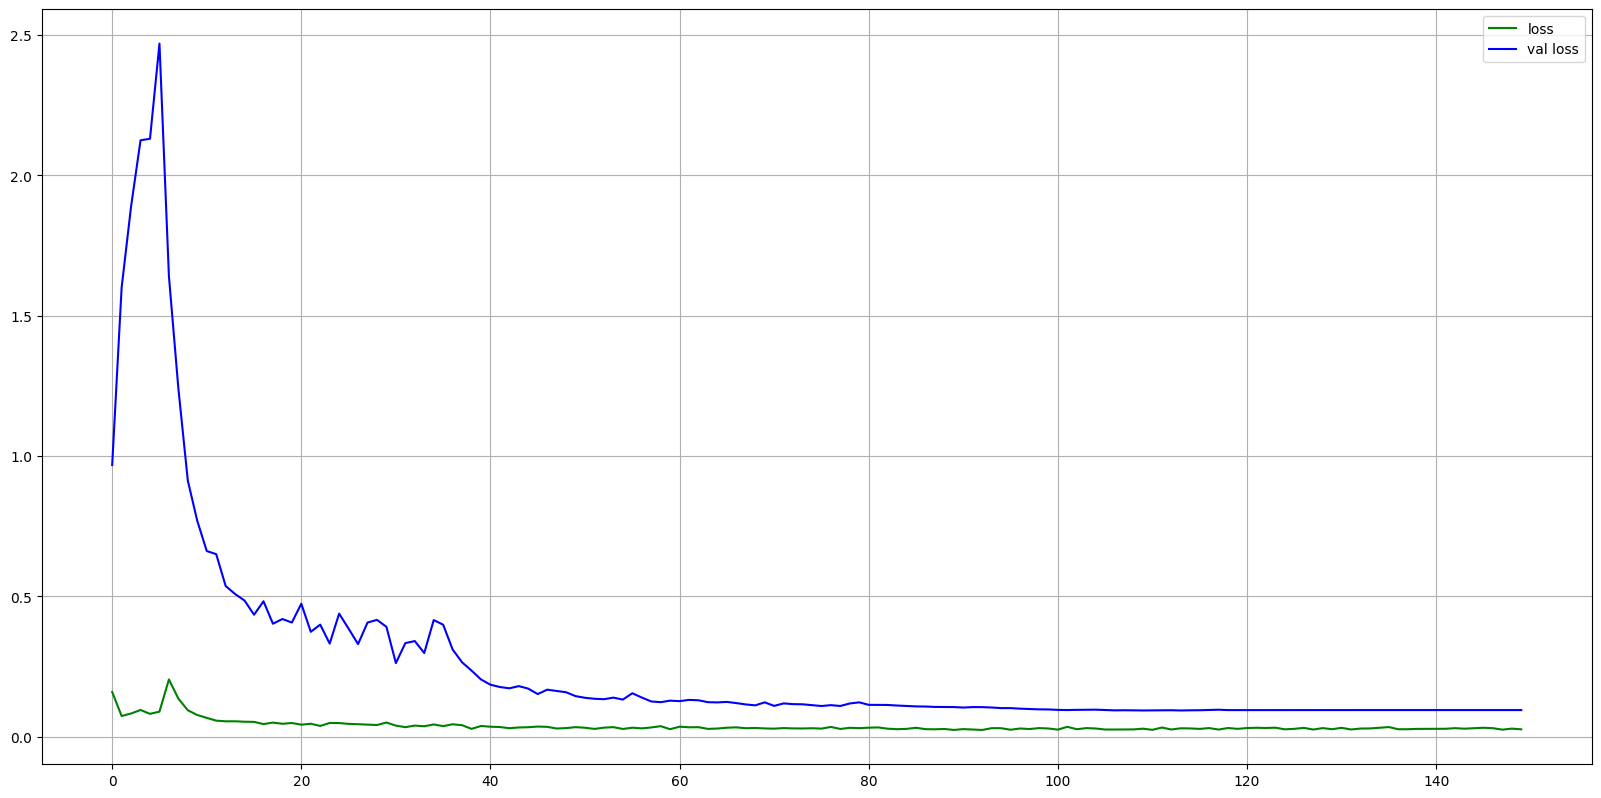

In [ ]:
plt.plot(history.history['loss'], 'g-', label='loss')
plt.plot(history.history['val_loss'], 'b-', label='val loss')
plt.legend()
plt.grid()
plt.show()

# Root Mean Square Error (RMSE)

> ## Scaled RMSE

In [ ]:
scl_train_pred = model.predict(X_train, batch_size=BATCH_SIZE)

print('Root Mean Squared Error of training: ')
print(np.sqrt(mean_squared_error(y_true=y_train, y_pred=scl_train_pred)))
print()

###############################################

scl_val_pred = model.predict(X_val, batch_size=BATCH_SIZE)

print('Root Mean Squared Error of validation: ')
print(np.sqrt(mean_squared_error(y_true=y_val, y_pred=scl_val_pred)))
print()

###############################################

scl_test_pred = model.predict(X_test, batch_size=BATCH_SIZE)

print('Root Mean Squared Error of testing: ')
np.sqrt(mean_squared_error(y_true=y_test, y_pred=scl_test_pred))


Root Mean Squared Error of training: 
0.10790107729765581

Root Mean Squared Error of validation: 
0.30743409506734104

Root Mean Squared Error of testing: 


0.40447836818541144

> ## RMSE of Smooth Data

In [ ]:
train_true = scaler.inverse_transform(y_train)
train_pred = scaler.inverse_transform(scl_train_pred)

std_train = np.std(train_true-train_pred)

train_true_invlog = InvLog(train_true, std_err=std_train)
train_pred_invlog = InvLog(train_pred, std_err=std_train)

print('Root Mean Squared Error of training: ')
print(np.sqrt(mean_squared_error(y_true=train_true_invlog, y_pred=train_pred_invlog)))
print()

#################################################

val_true = scaler.inverse_transform(y_val)
val_pred = scaler.inverse_transform(scl_val_pred)

std_val = np.std(val_true-val_pred)

val_true_invlog = InvLog(val_true, std_err=std_val)
val_pred_invlog = InvLog(val_pred, std_err=std_val)

print('Root Mean Squared Error of validation: ')
print(np.sqrt(mean_squared_error(y_true=val_true_invlog, y_pred=val_pred_invlog)))
print()

###################################################

test_true = scaler.inverse_transform(y_test)
test_pred = scaler.inverse_transform(scl_test_pred)

std_test = np.std(test_true-test_pred)

test_true_invlog = InvLog(test_true, std_err=std_test)
test_pred_invlog = InvLog(test_pred, std_err=std_test)

print('Root Mean Squared Error of testing: ')
print(np.sqrt(mean_squared_error(y_true=test_true_invlog, y_pred=test_pred_invlog)))


Root Mean Squared Error of training: 
117.74412942626856

Root Mean Squared Error of validation: 
843.3680219144223

Root Mean Squared Error of testing: 
1233.9799427749804


> ## RMSE of True Data

In [ ]:
scl_train_pred_NJ = model.predict(X_train_NJ, batch_size=BATCH_SIZE)

train_true_NJ = scaler_NJ.inverse_transform(y_train_NJ)
train_pred_NJ = scaler_NJ.inverse_transform(scl_train_pred_NJ)

std_train_NJ = np.std(train_true_NJ-train_pred_NJ)

train_true_invlog_NJ = InvLog(train_true_NJ, std_err=std_train_NJ)
train_pred_invlog_NJ = InvLog(train_pred_NJ, std_err=std_train_NJ)

print('Root Mean Squared Error of training: ')
print(np.sqrt(mean_squared_error(y_true=train_true_invlog_NJ, y_pred=train_pred_invlog_NJ)))
print()

#################################################

scl_val_pred_NJ = model.predict(X_val_NJ, batch_size=BATCH_SIZE)

val_true_NJ = scaler_NJ.inverse_transform(y_val_NJ)
val_pred_NJ = scaler_NJ.inverse_transform(scl_val_pred_NJ)

std_val_NJ = np.std(val_true_NJ-val_pred_NJ)

val_true_invlog_NJ = InvLog(val_true_NJ, std_err=std_val_NJ)
val_pred_invlog_NJ = InvLog(val_pred_NJ, std_err=std_val_NJ)

print('Root Mean Squared Error of training: ')
print(np.sqrt(mean_squared_error(y_true=val_true_invlog_NJ, y_pred=val_pred_invlog_NJ)))
print()

###################################################

scl_test_pred_NJ = model.predict(X_test_NJ, batch_size=BATCH_SIZE)

test_true_NJ = scaler_NJ.inverse_transform(y_test_NJ)
test_pred_NJ = scaler_NJ.inverse_transform(scl_test_pred_NJ)

std_test_NJ = np.std(test_true_NJ-test_pred_NJ)

test_true_invlog_NJ = InvLog(test_true_NJ, std_err=std_test_NJ)
test_pred_invlog_NJ = InvLog(test_pred_NJ, std_err=std_test_NJ)

print('Root Mean Squared Error of training: ')
print(np.sqrt(mean_squared_error(y_true=test_true_invlog_NJ, y_pred=test_pred_invlog_NJ)))


Root Mean Squared Error of training: 
355.0277003782382

Root Mean Squared Error of training: 
1109.610357040749

Root Mean Squared Error of training: 
1684.8098210352387


# Log Prediction Plot

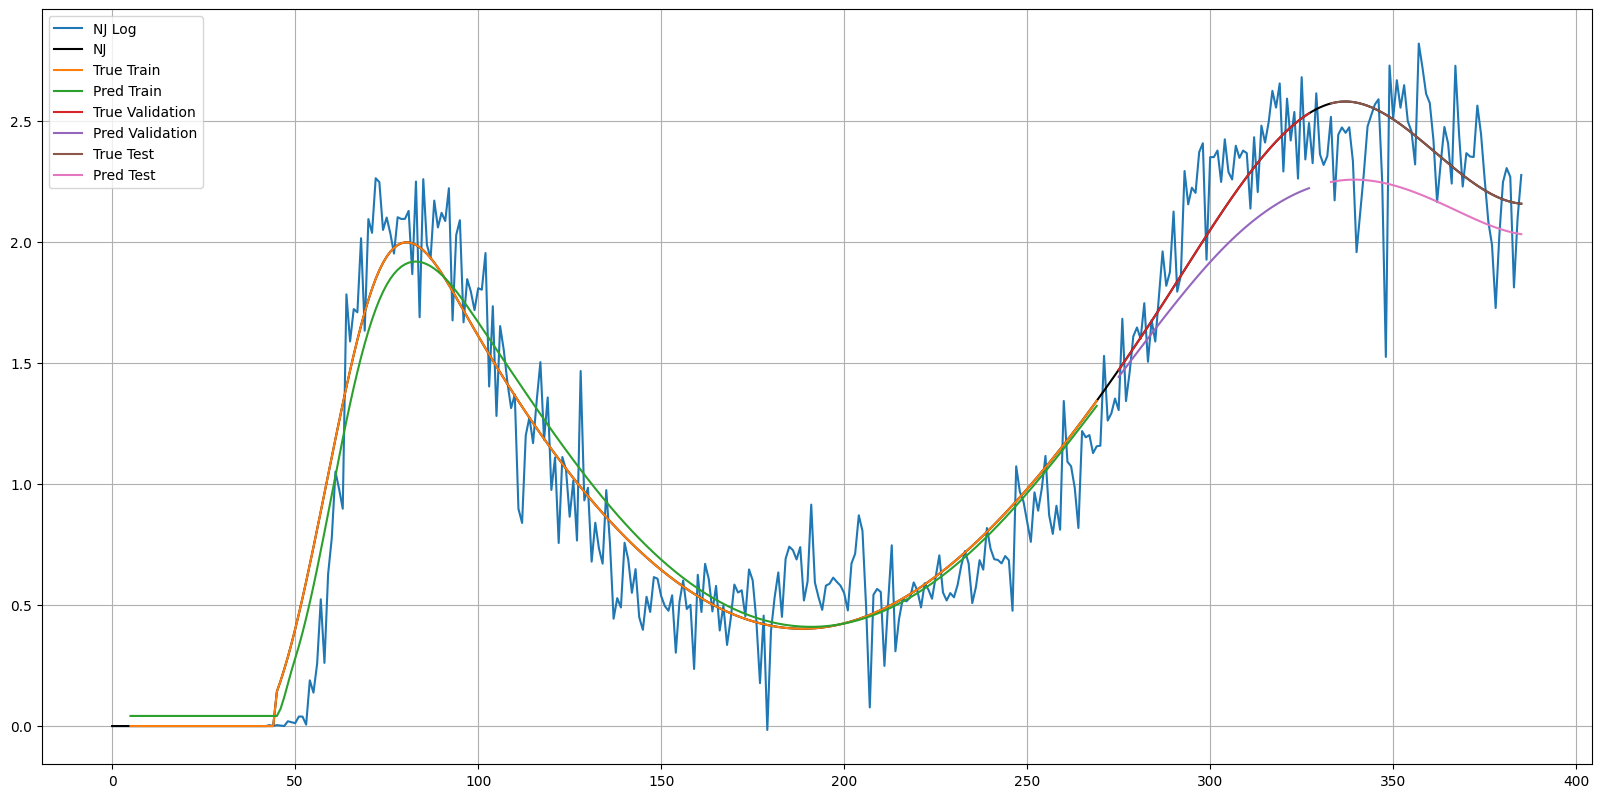

In [ ]:
plt.plot(NJ_log, label='NJ Log')
plt.plot(NJ, 'k-', label='NJ')

plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_true, label='True Train')
plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_pred, label='Pred Train')

plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_true, label='True Validation')
plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_pred, label='Pred Validation')

plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_true, label='True Test')
plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_pred, label='Pred Test')

plt.grid()
plt.legend(loc='best')
plt.show()

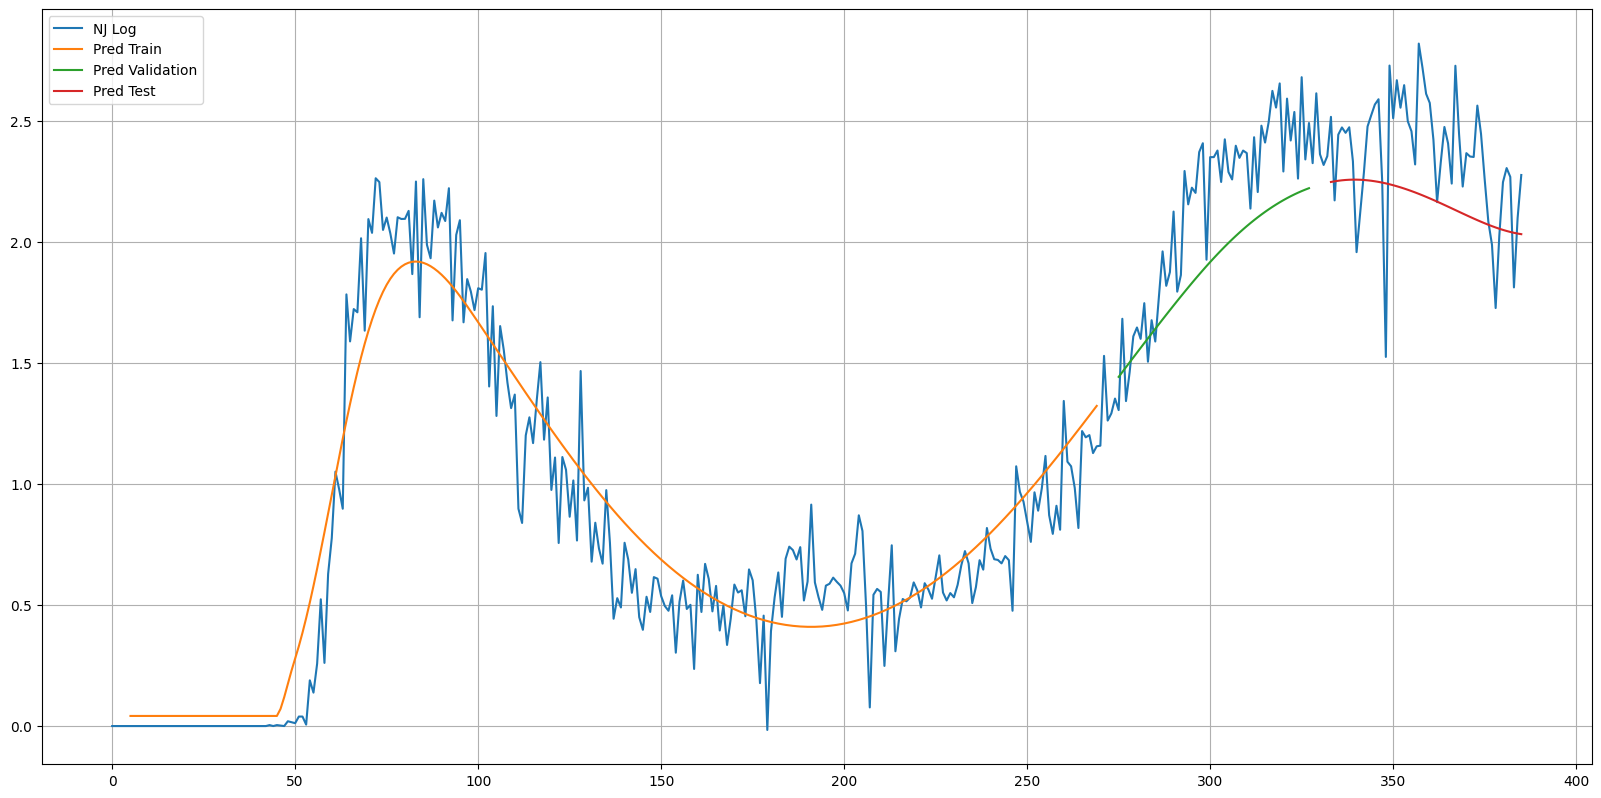

In [ ]:
plt.plot(NJ_log, label='NJ Log')
#plt.plot(NJ, 'k-', label='NJ')

#plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_true, label='True Train')
plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_pred, label='Pred Train')

#plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_true, label='True Validation')
plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_pred, label='Pred Validation')

#plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_true, label='True Test')
plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_pred, label='Pred Test')

plt.grid()
plt.legend(loc='best')
plt.show()

# True Prediction Plot

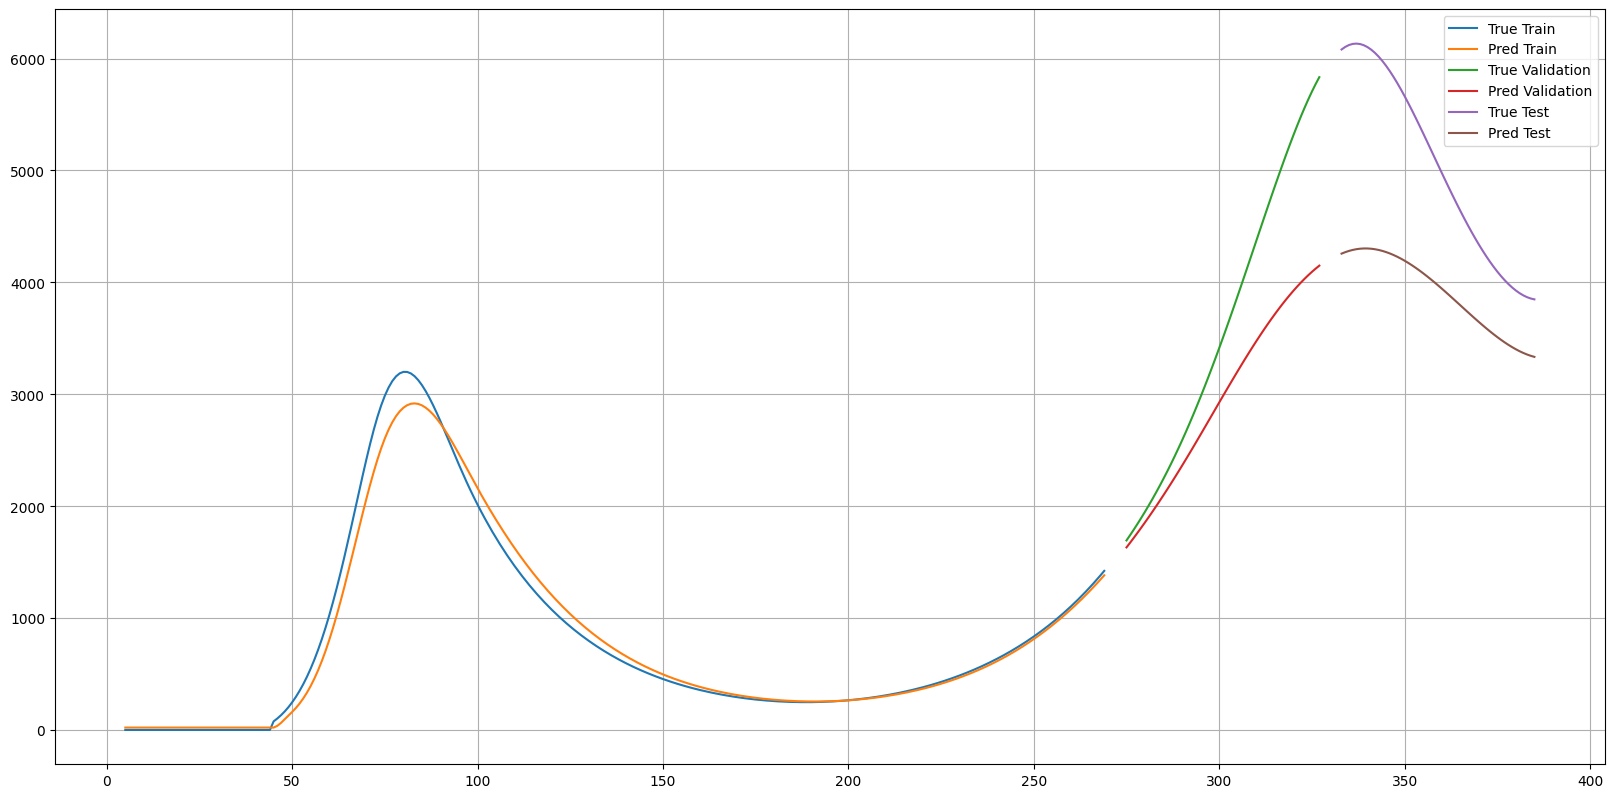

In [ ]:
plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_true_invlog, label='True Train')
plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_pred_invlog, label='Pred Train')

plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_true_invlog, label='True Validation')
plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_pred_invlog, label='Pred Validation')

plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_true_invlog, label='True Test')
plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_pred_invlog, label='Pred Test')

plt.grid()
plt.legend()
plt.show()

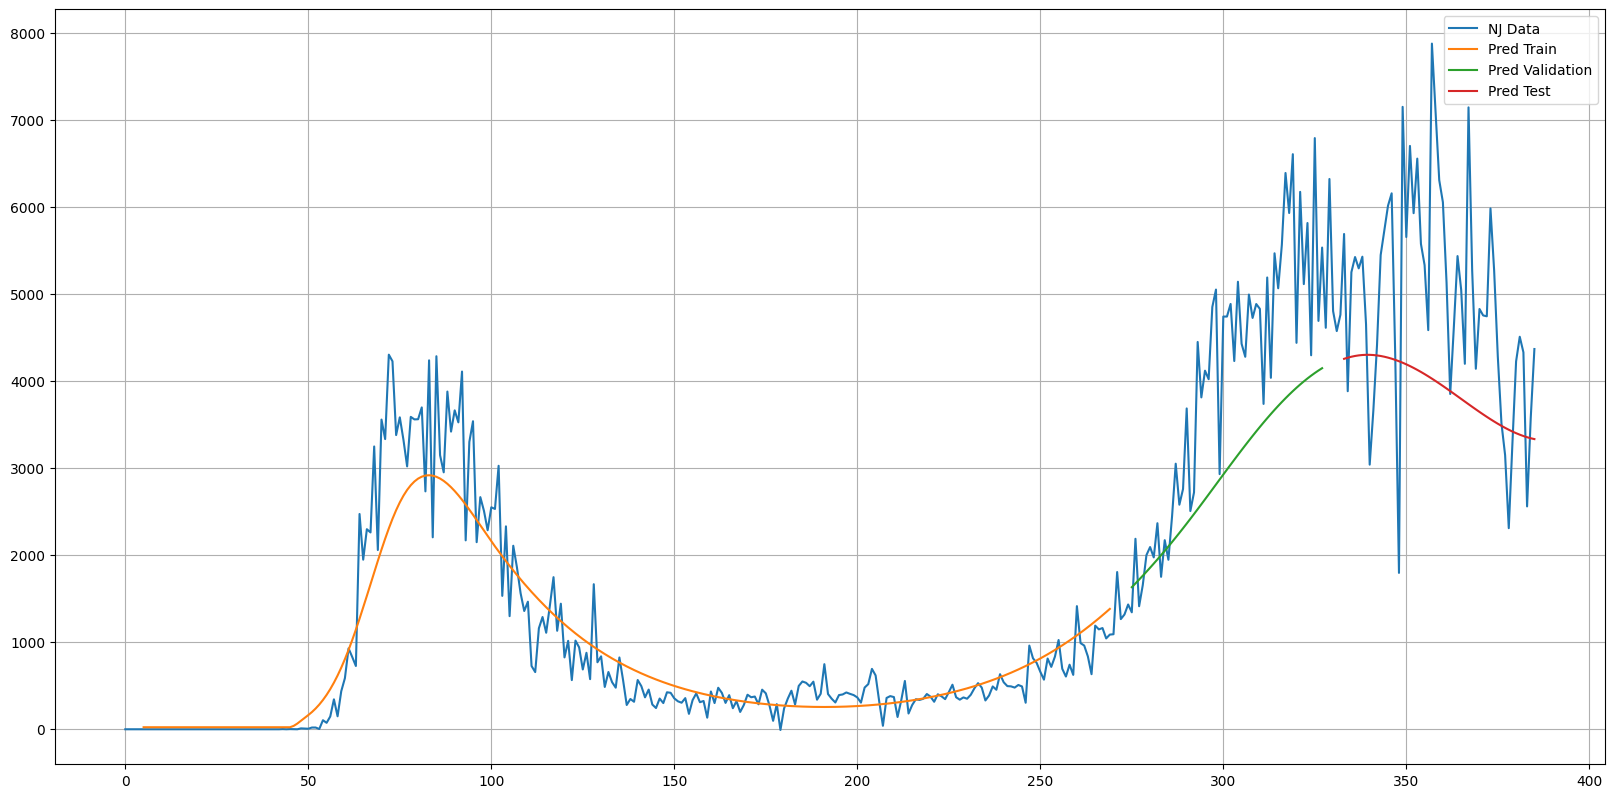

In [ ]:
plt.plot(NJ_data, label='NJ Data')

#plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_true_invlog, label='True Train')
plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_pred_invlog, label='Pred Train')

#plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_true_invlog, label='True Validation')
plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_pred_invlog, label='Pred Validation')

#plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_true_invlog, label='True Test')
plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_pred_invlog, label='Pred Test')

plt.grid()
plt.legend()
plt.show()

> ## Train Prediction Plot

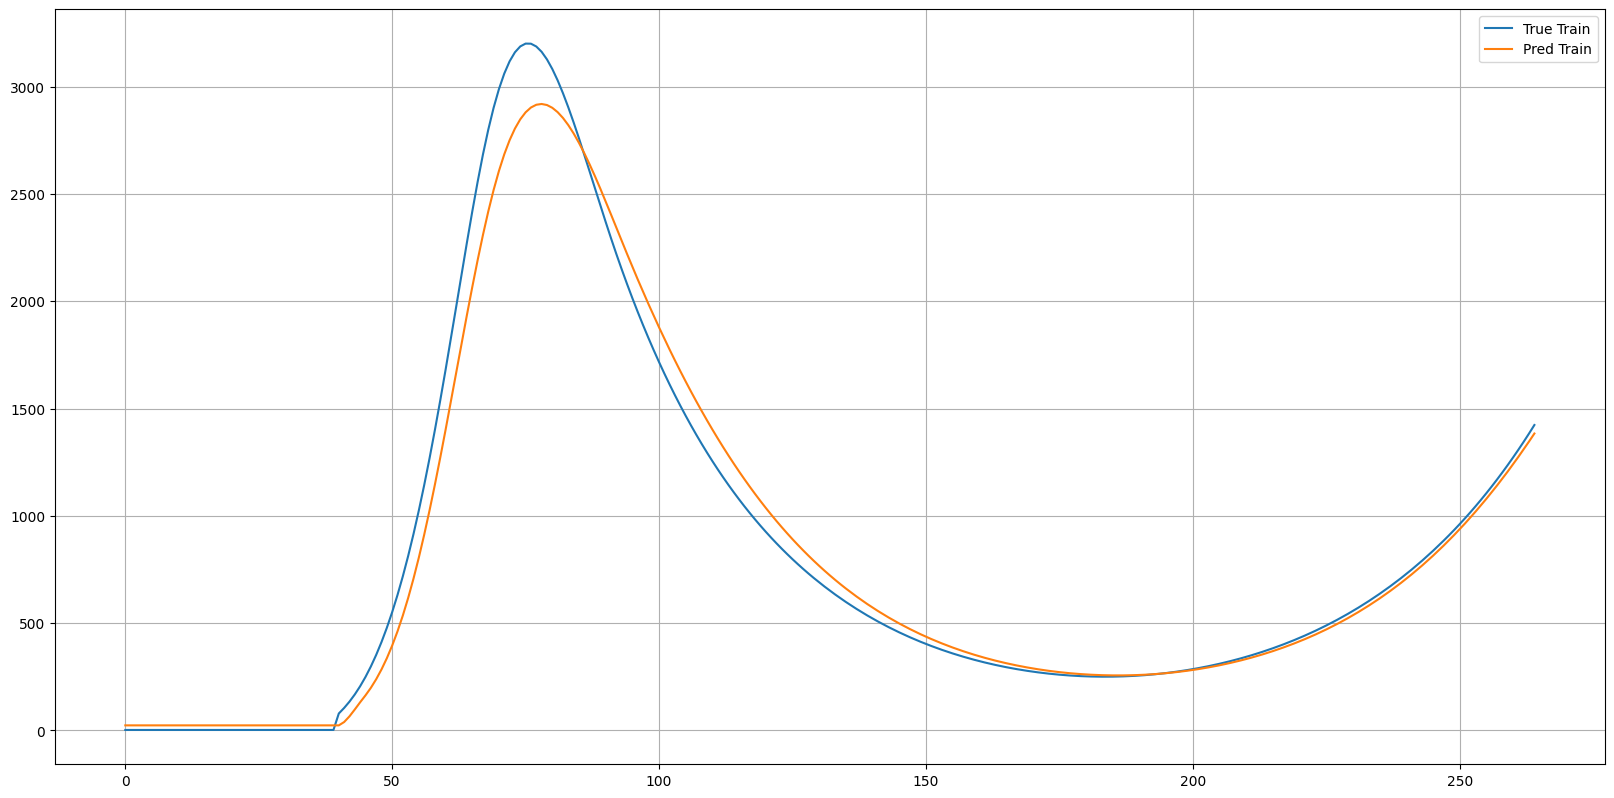

In [ ]:
plt.plot(train_true_invlog, label='True Train')
plt.plot(train_pred_invlog, label='Pred Train')

plt.grid()
plt.legend()
plt.show()

> ## Validation Prediction Plot

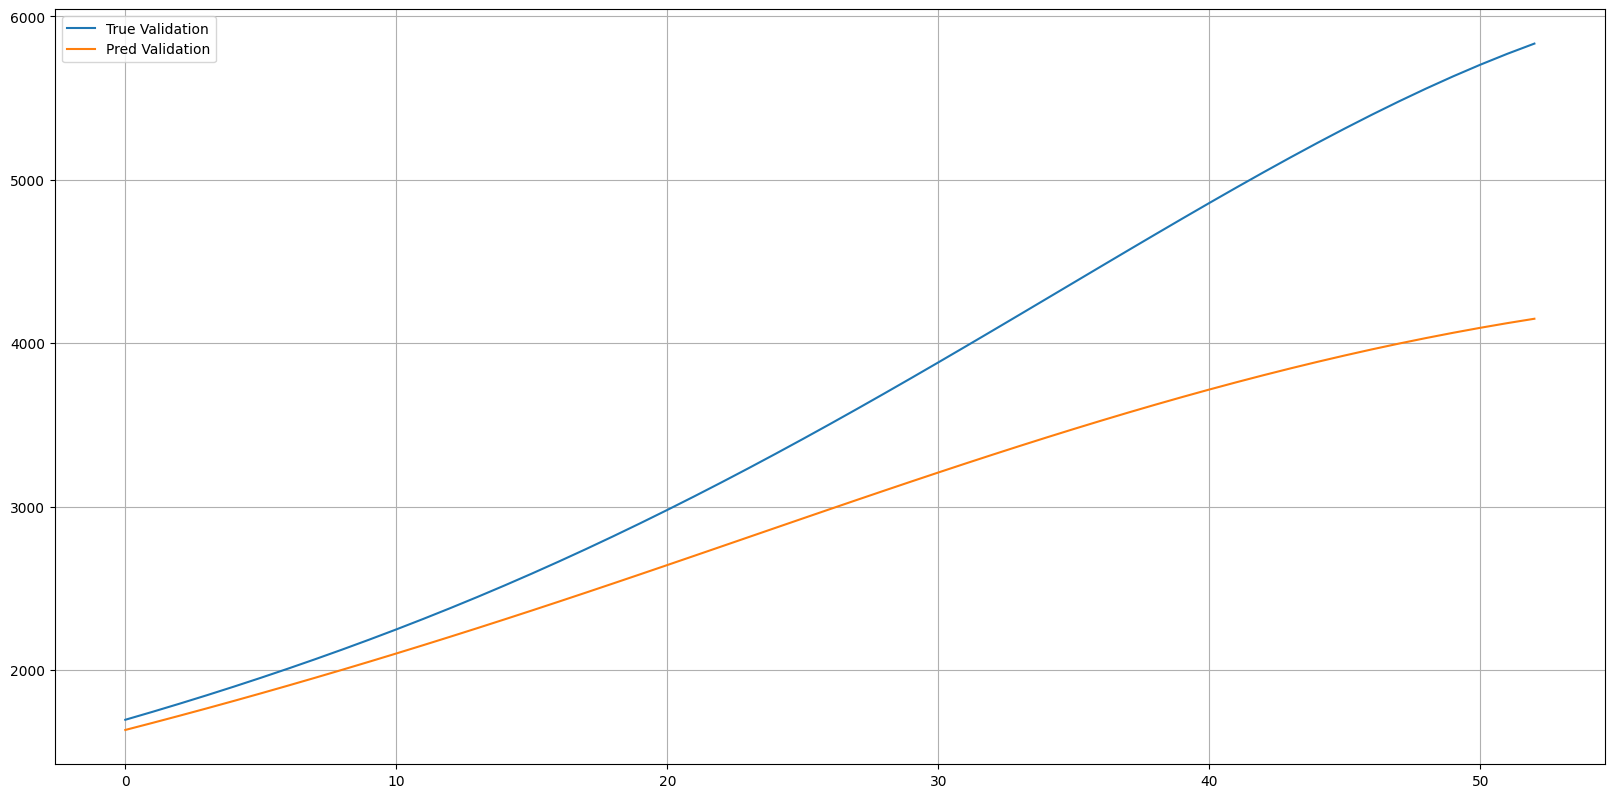

In [ ]:
plt.plot(val_true_invlog, label='True Validation')
plt.plot(val_pred_invlog, label='Pred Validation')

plt.grid()
plt.legend()
plt.show()

> ## Test Prediction Plot

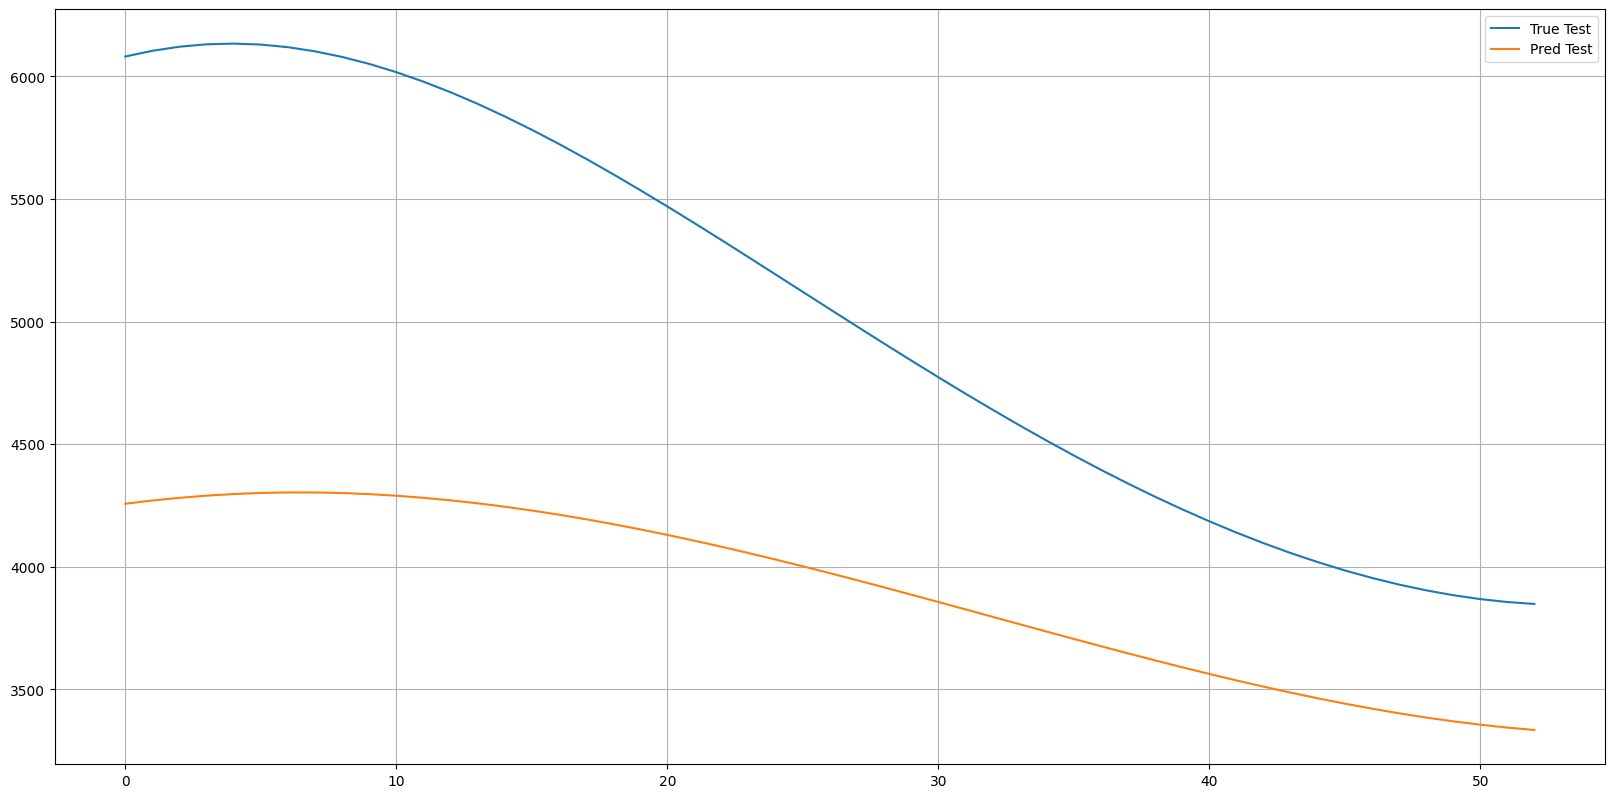

In [ ]:
plt.plot(test_true_invlog, label='True Test')
plt.plot(test_pred_invlog, label='Pred Test')

plt.grid()
plt.legend()
plt.show()

# Forecasting

In [ ]:
x_input = X_test[-1:].flatten()
temp_input=list(x_input)

lst_output=[]
i=0
FORECASTED_DAYS = 30

while(i<FORECASTED_DAYS):
    
    if(len(temp_input)>TIME_STEPS):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, TIME_STEPS, n_features))
        #print(x_input)
        yhat = model.predict(x_input, batch_size=BATCH_SIZE)
        #print(f"{i} day output {yhat}")
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, TIME_STEPS, n_features))
        #print("{} day input {}".format(i,x_input.flatten()))
        yhat = model.predict(x_input, batch_size=BATCH_SIZE)
        #print(f"{i} day output {yhat}")
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

In [ ]:
scale_forecast = scaler.inverse_transform(lst_output)

forecast = InvLog(scale_forecast)
#forecast

In [ ]:
"""plt.plot(range(len(NJ)), InvLog(NJ), label='NJ')
plt.plot(range(len(NJ), len(NJ)+FORECASTED_DAYS), forecast, label='Forecasted')
plt.grid()
plt.legend(loc=2)
plt.show()"""

"plt.plot(range(len(NJ)), InvLog(NJ), label='NJ')\nplt.plot(range(len(NJ), len(NJ)+FORECASTED_DAYS), forecast, label='Forecasted')\nplt.grid()\nplt.legend(loc=2)\nplt.show()"

# Forecasted Plot

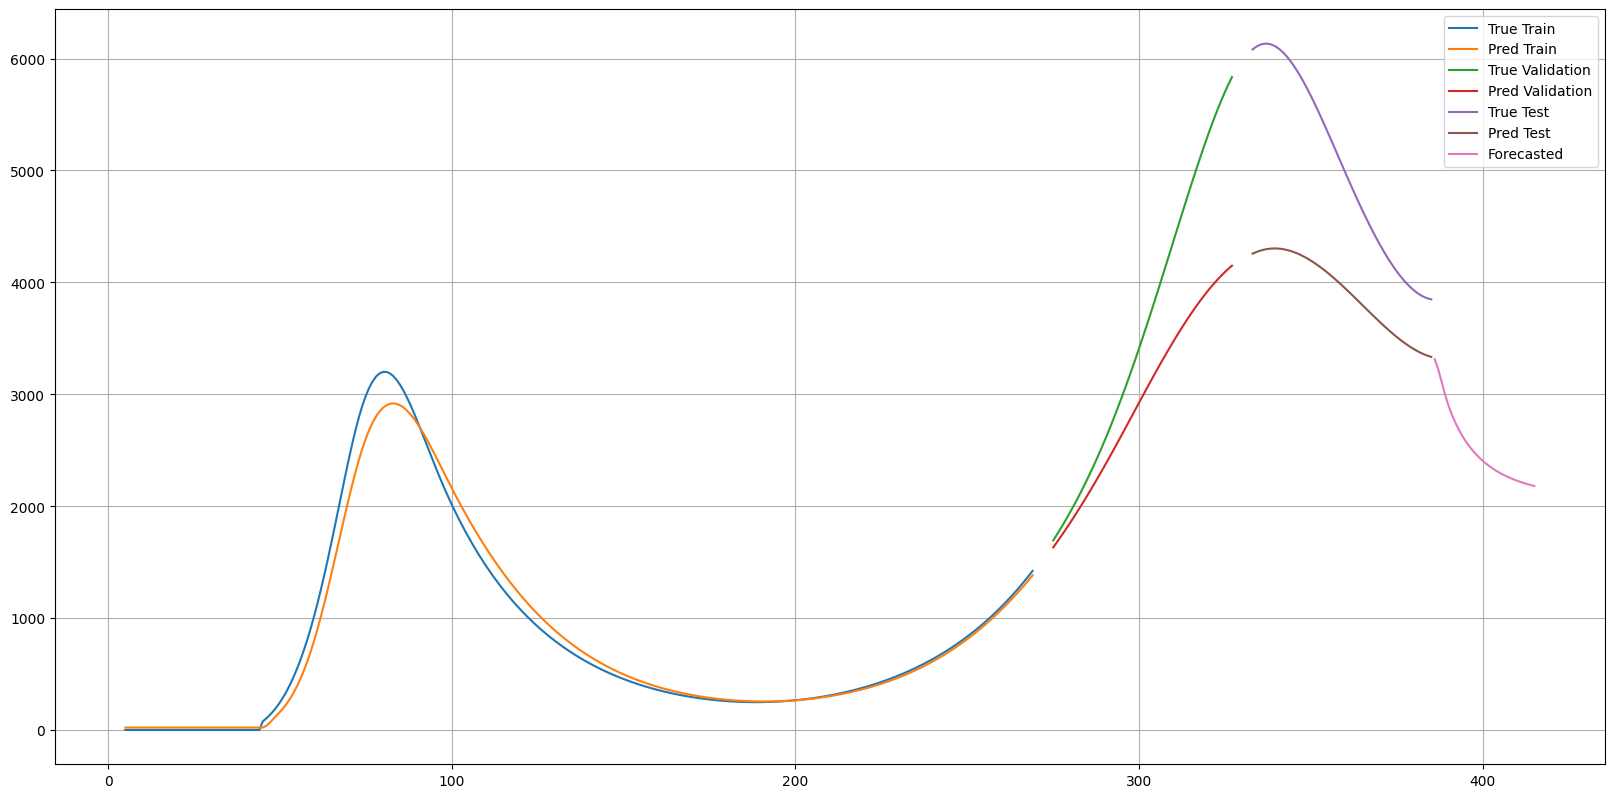

In [ ]:
plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_true_invlog, label='True Train')
plt.plot(range(TIME_STEPS,len(train_true)+TIME_STEPS) ,train_pred_invlog, label='Pred Train')

plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_true_invlog, label='True Validation')
plt.plot(range(len(train_true)+TIME_STEPS*2, len(train_true)+TIME_STEPS*2+len(val_true)) ,val_pred_invlog, label='Pred Validation')

plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_true_invlog, label='True Test')
plt.plot(range(len(train_true)+TIME_STEPS*3+len(val_true), len(NJ)) ,test_pred_invlog, label='Pred Test')

plt.plot(range(len(NJ), len(NJ)+FORECASTED_DAYS) ,forecast, label='Forecasted')

plt.grid()
plt.legend()
plt.show()

# NJ Dataframe

In [ ]:
dates = []
for i in confirmed.columns[1:]:
  dates.append(datetime.datetime.strptime(i, '%m/%d/%y').date())

In [ ]:
true_data = np.append(np.pad(train_true_invlog.flatten(), pad_width=(TIME_STEPS,0), mode='constant', constant_values=np.nan), 
             np.pad(val_true_invlog.flatten(), pad_width=(TIME_STEPS,0), mode='constant', constant_values=np.nan))

true_data = np.append(true_data,np.pad(test_true_invlog.flatten(), pad_width=(TIME_STEPS,0), mode='constant', constant_values=np.nan))

In [ ]:
pred_data = np.append(np.pad(train_pred_invlog.flatten(), pad_width=(TIME_STEPS,0), mode='constant', constant_values=np.nan), 
             np.pad(val_pred_invlog.flatten(), pad_width=(TIME_STEPS,0), mode='constant', constant_values=np.nan))

pred_data = np.append(pred_data,np.pad(test_pred_invlog.flatten(), pad_width=(TIME_STEPS,0), mode='constant', constant_values=np.nan))

In [ ]:
df = pd.DataFrame(data={'dates':dates, 'njData':NJ_data, 'njSmooth':InvLog(NJ), 'true':true_data, 'pred':pred_data})
#df = df.astype({'dates':np.datetime64})
df.tail(10)

,dates,njData,njSmooth,true,pred
376,2021-02-01,3517,4031.740970,4056.374486,3487.131836
377,2021-02-02,3150,3994.843096,4019.276044,3463.995850
378,2021-02-03,2311,3961.138067,3985.387802,3442.159180
379,2021-02-04,3289,3930.745045,3954.829571,3421.735107
380,2021-02-05,4228,3903.785152,3927.723130,3402.825195
381,2021-02-06,4511,3880.382643,3904.193410,3385.539551
382,2021-02-07,4332,3860.666146,3884.369739,3369.986084
383,2021-02-08,2561,3844.769965,3868.387149,3356.266113
384,2021-02-09,3576,3832.835443,3856.387754,3344.488525
385,2021-02-10,4370,3825.012426,3848.522213,3334.756348


In [ ]:
start_date = df.dates.values[-1]
print(start_date)

2021-02-10


In [ ]:
day = []
for i in range(1, FORECASTED_DAYS + 1):
    day.append(start_date + datetime.timedelta(days=i))

print(day)

[datetime.date(2021, 2, 11), datetime.date(2021, 2, 12), datetime.date(2021, 2, 13), datetime.date(2021, 2, 14), datetime.date(2021, 2, 15), datetime.date(2021, 2, 16), datetime.date(2021, 2, 17), datetime.date(2021, 2, 18), datetime.date(2021, 2, 19), datetime.date(2021, 2, 20), datetime.date(2021, 2, 21), datetime.date(2021, 2, 22), datetime.date(2021, 2, 23), datetime.date(2021, 2, 24), datetime.date(2021, 2, 25), datetime.date(2021, 2, 26), datetime.date(2021, 2, 27), datetime.date(2021, 2, 28), datetime.date(2021, 3, 1), datetime.date(2021, 3, 2), datetime.date(2021, 3, 3), datetime.date(2021, 3, 4), datetime.date(2021, 3, 5), datetime.date(2021, 3, 6), datetime.date(2021, 3, 7), datetime.date(2021, 3, 8), datetime.date(2021, 3, 9), datetime.date(2021, 3, 10), datetime.date(2021, 3, 11), datetime.date(2021, 3, 12)]


In [ ]:
df2 = pd.DataFrame({'dates':day, 'forecast':forecast})
df2.tail(10)

,dates,forecast
20,2021-03-03,2281.337402
21,2021-03-04,2266.306641
22,2021-03-05,2252.474854
23,2021-03-06,2239.729004
24,2021-03-07,2227.968750
25,2021-03-08,2217.104492
26,2021-03-09,2207.057373
27,2021-03-10,2197.755859
28,2021-03-11,2189.136963
29,2021-03-12,2181.143311
